In [113]:
import numpy as np
import os, os.path
import csv 
from sklearn.utils import shuffle
from sklearn.model_selection import  StratifiedKFold
from collections import namedtuple
from sklearn import tree
import math
import matplotlib.pyplot as plt


In [114]:
def LoadIonosphere(Location):
    Data = []
    for FileName in os.listdir(Location):
        if FileName.endswith(".csv"):
            with open(Location + '/'+FileName, 'r') as File: 
                csvReader = csv.reader(File)
                for Row in csvReader:        
                    Data.append(Row) 
    X = []
    Y = []
    Flag = True
    for Row in Data : 
        if Flag : 
            Flag = False
            continue 
        i = 0 
        n = len(Row)-1
        RowX = []
        for Value in Row : 
            if i < n :
                RowX.append(float(Value))
            else:
                Y.append(Value)
            i = i+1 
        X.append(RowX)
    return np.array(X) , np.array(Y) 


In [115]:
def TestLearn():
    K = 5 
    DataX , DataY = LoadIonosphere("../") # X ,Y
    DataX , DataY = shuffle(DataX , DataY)
    UniqueClass = np.unique(DataY)  #u
    Labels = np.zeros(len(DataY))   #labels
    for i  in range(0,len(DataY)):
        for j in range(0,len(UniqueClass)):
            if UniqueClass[j] == DataY [i] : 
                Labels[i] = j
                break 
    DataTrainCell = []
    LabelTrainCell = []
    DataTestCell = []
    LabelTestCell = []
    skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
    for train_index, test_index in skf.split(DataX, Labels):
        #print("TRAIN:", train_index )
        #print( "TEST:", test_index)
        DataTrainCell.append(DataX[train_index])
        DataTestCell.append(DataX[test_index])
        LabelTrainCell.append(Labels[train_index])
        LabelTestCell.append(Labels[test_index])
        
    MyStructModel = namedtuple( "MyStructModel", "Type")
    Model = MyStructModel (Type ="Cart")
    MyStructNet = namedtuple( "MyStructNet", "base_classifier iterations mclass classifiers beta")
    Net = MyStructNet (base_classifier = Model ,iterations =  3 , mclass =len(UniqueClass) , 
                       classifiers = None , beta = None)
    return Learn(Net , DataTrainCell,LabelTrainCell,DataTestCell,LabelTestCell)
     

In [116]:
def CalculateEpsilon (D , PredictionSet , Labels ) :
    PredictionSet = np.array(PredictionSet)
    Labels = np.array(Labels)
    ErrorIndeces = np.where(PredictionSet !=Labels)[0]
    EpsilonKT = sum(np.take(D, ErrorIndeces))
    return EpsilonKT / (1 - EpsilonKT)

In [192]:
def ClassifyEnsemble (NetBeta, Netmclass, NetClassifiers , Data, Label, Limit):
    Weights = []
    for Value in (np.array(NetBeta)) : 
        #print(Value)
        if Value == 0 :
            np.inf
            Weights.append(np.inf)
        else :
            Weights.append(math.log10(1/Value))
    Weights = np.array(Weights)
    P = np.zeros((len(Label),Netmclass))
    for k in range(0,Limit) :
        PredictionK = NetClassifiers[k].predict(Data)
        PredictionK = np.array(PredictionK)
        #print(PredictionK.shape ,P.shape , Weights.shape )
        
        for m in range(0, len(PredictionK)) : 
            #print("[m]" ,m )
            #print("PredictionK[m]" ,PredictionK[m] )
            #print("P[m,PredictionK[m]] " ,P[m][int(PredictionK[m])]  )
            P[m][int(PredictionK[m])]  = P[m][int(PredictionK[m])] + Weights[k]
    return np.argmax(P,axis=1) , np.matlib.repmat(np.sum(P,axis = 1)[..., None],1,2)

In [217]:
def Learn(Net , DataTrain , LabelTrain, DataTest, LabelTest):
    Tk = Net.iterations #number of classifiers to generate
    K = len(DataTrain) #number of data sets 
    ###### porer code ta kaj na korle aita use kormu
    #NetClassifiers = []
    #for i in range(0,Tk*K) : 
    #    NetClassifiers.append([])
    #NetClassifiers = np.array(NetClassifiers)
    #
    NetClassifiers = []
    NetBeta = []
    ClassifierCout = 0
    Error = []
    
    for IndexK in range(0,K):
        DataTrainK = DataTrain[IndexK]
        LabelTrainK = LabelTrain[IndexK]
        DataTestK = DataTest[IndexK]
        LabelTestK = LabelTest[IndexK]
        TrainLength = len(LabelTrainK)
        D = np.ones(TrainLength) / TrainLength
        if IndexK > 0 :
            #print("if K > 0 :")
            PredictionsTrainEnsemble , Posterior = ClassifyEnsemble (NetBeta, Net.mclass,
                                NetClassifiers ,DataTrainK, LabelTrainK, ClassifierCout)
            EpsilonKT = CalculateEpsilon(D,PredictionsTrainEnsemble,LabelTrainK)
            BetaKT = EpsilonKT / (1-EpsilonKT)
            MatchedIndeces = np.where(PredictionsTrainEnsemble ==LabelTrainK)[0]
            np.put(D, MatchedIndeces, BetaKT* np.take(D, MatchedIndeces))
            
        for t in range(0,Tk) : 
            D = D / np.sum(D)

            #ki kormu bujtasi na bal
            if len(DataTrainK) == len(LabelTrainK):
                clf = tree.DecisionTreeClassifier()
                NetClassifiers.append(clf.fit(DataTrainK, LabelTrainK))
                PredictionOnTrainSet = NetClassifiers[ClassifierCout].predict(DataTrainK)
                NetBeta.append(CalculateEpsilon(D,PredictionOnTrainSet , LabelTrainK))  
                #print("NetBeta :" , NetBeta)
                PredictionsTrainEnsemble , Posterior = ClassifyEnsemble (NetBeta, Net.mclass,
                                NetClassifiers ,DataTrainK, LabelTrainK, ClassifierCout)
                EpsilonKT = CalculateEpsilon(D,PredictionsTrainEnsemble,LabelTrainK)
                if EpsilonKT > 0.5 : 
                    EpsilonKT = 0.5
                BetaKT = EpsilonKT / (1-EpsilonKT)
                
                MatchedIndeces = np.where(PredictionsTrainEnsemble ==LabelTrainK)[0]
                np.put(D, MatchedIndeces, BetaKT* np.take(D, MatchedIndeces))
                D = D / np.sum(D)
                
    
                PredictionsTestEnmble , Posterior = ClassifyEnsemble (NetBeta, Net.mclass,
                                NetClassifiers ,DataTestK, LabelTestK, ClassifierCout)
                Error.append(len(np.where(PredictionsTestEnmble 
                                          != LabelTestK)[0]) / len(LabelTestK))
                #PredictionOnTestSet = NetClassifiers[ClassifierCout].predict(DataTestK)
                #NetBeta = CalculateEpsilon(D,PredictionOnTrainSet , LabelTrainK)
                #PredictionOnTestSet = np.array(PredictionOnTestSet)
                #LabelTestK = np.array(LabelTest[IndexK])
                #TestSetError = np.where(PredictionOnTestSet !=LabelTestK)[0]
                #print("TestSetError" , TestSetError)
                #b = sum(np.take(D, TestSetError))
                #print("b" , b)

            else:
                print("Error")
            if (Error[ClassifierCout]) == 0 : 
                print("t = " , t , " , Error 0 asse")
            ClassifierCout = ClassifierCout + 1 

            
    return Error , ClassifierCout

In [218]:
Error , Count = TestLearn()
print(Count)
print(len(Error))
print(Error)

t =  0  , Error 0 asse
t =  0  , Error 0 asse
t =  0  , Error 0 asse
t =  0  , Error 0 asse
15
15
[0.6338028169014085, 0.14084507042253522, 0.14084507042253522, 0.0, 0.08571428571428572, 0.08571428571428572, 0.0, 0.05714285714285714, 0.05714285714285714, 0.0, 0.014285714285714285, 0.02857142857142857, 0.0, 0.02857142857142857, 0.04285714285714286]


<ipython-input-217-3636ddf93df2>:50: RuntimeWarning: invalid value encountered in true_divide
  D = D / np.sum(D)


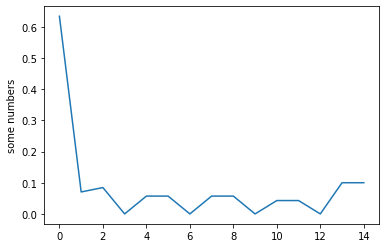

In [208]:
plt.plot(Error)
plt.ylabel('some numbers')
plt.show()

